In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.cm as cm
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.stats as stats
import pandas
import glob
import scipy.ndimage as ndimage
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='50m',facecolor='none')
cline50m = cfeature.NaturalEarthFeature(category='physical',name='coastline',scale='50m',facecolor='none')

threshold=-10

In [6]:
soidata=np.genfromtxt('soi_monthly.txt',delimiter=',')
np.datetime64('{:.0f}'.format(soidata[0,0]/100)+'-'+'{:02.0f}'.format(soidata[0,0]%100))

first=True
for row in soidata:
    if first:
        months=np.array([np.datetime64('{:.0f}'.format(row[0]/100)+'-'+'{:02.0f}'.format(row[0]%100))])
        soi=row[1:]
        first=False
    else:
        months=np.concatenate([months,np.array([np.datetime64('{:.0f}'.format(row[0]/100)+'-'+'{:02.0f}'.format(row[0]%100))])])
        soi=np.concatenate([soi,row[1:]])
soi[soi==-9999]=np.nan
smooth_soi=ndimage.uniform_filter1d(soi,5,mode='nearest')

positive_soi_months=months[smooth_soi>=7]
lanina_seasons=np.concatenate([np.arange(month, month+np.timedelta64(1,'M'), dtype='datetime64[D]') for month in positive_soi_months])
negative_soi_months=months[smooth_soi<=-7]
elnino_seasons=np.concatenate([np.arange(month, month+np.timedelta64(1,'M'), dtype='datetime64[D]') for month in negative_soi_months])

In [7]:
latlon=pandas.read_csv('../data/acorn_sat/acorn_sat_v2.1.0_daily_tmax/acorn_sat_v2.1.0_stations.csv',usecols=[0,2,3]).to_xarray().swap_dims({"index": "stn_num"})
ids=[]
names=[]
q=0
first=True
for n in glob.glob('../data/acorn_sat/acorn_sat_v2.1.0_daily_tmax/tmax.*.daily.csv'):
    site_name=pandas.read_csv(n,usecols=[3])[0:1]['site name'][0]
    station_id=pandas.read_csv(n,usecols=[2])[0:1]['site number'][0]
    lat=latlon['lat'].loc[station_id]
    if lat>-23.44:
        continue
    else:
        print(q,site_name)
        import_xr=pandas.read_csv(n,usecols=[0,1],parse_dates=['date'],dayfirst=True)[1:].to_xarray()
        tx_station=import_xr.swap_dims({"index": "date"})['maximum temperature (degC)']
        tx_station_diff=tx_station.diff(dim='date',label='lower').drop_vars('index')
        cluster_param=tx_station_diff.resample(date='M').min()
        ids.append(station_id)
        names.append(site_name)
        q+=1
        if first:
            diff_table=tx_station_diff
            clust_table=cluster_param
            first=False
        else:
            diff_table=xr.concat([diff_table,tx_station_diff],dim='station')
            clust_table=xr.concat([clust_table,cluster_param],dim='station')
diff_table=diff_table.assign_coords(station=np.arange(0,87,1))
ids=np.array(ids).astype(int)

0 CARNARVON AIRPORT
1 MEEKATHARRA AIRPORT
2 MORAWA AIRPORT
3 DALWALLINU
4 GERALDTON AIRPORT
5 PERTH AIRPORT
6 CAPE LEEUWIN
7 BRIDGETOWN
8 ESPERANCE
9 ALBANY AIRPORT
10 MERREDIN
11 CUNDERDIN AIRFIELD
12 KATANNING
13 WANDERING
14 EUCLA
15 FORREST
16 KALGOORLIE-BOULDER AIRPORT
17 GILES METEOROLOGICAL OFFICE
18 ALICE SPRINGS AIRPORT
19 WOOMERA AERODROME
20 TARCOOLA AERO
21 OODNADATTA AIRPORT
22 MARREE AERO
23 CEDUNA AMO
24 KYANCUTTA
25 PORT LINCOLN AWS
26 RAYVILLE PARK
27 CAPE BORDA
28 KENT TOWN
29 NURIOOTPA PIRSA
30 MOUNT GAMBIER AERO
31 ROBE
32 BARCALDINE POST OFFICE
33 LONGREACH AERO
34 BIRDSVILLE AIRPORT
35 GAYNDAH AIRPORT
36 BUNDABERG AERO
37 AMBERLEY AMO
38 CAPE MORETON LIGHTHOUSE
39 BRISBANE AERO
40 MILES CONSTANCE STREET
41 ST GEORGE AIRPORT
42 CHARLEVILLE AERO
43 THARGOMINDAH AIRPORT
44 WILCANNIA AERODROME AWS
45 TIBOOBURRA AIRPORT
46 COBAR MO
47 BOURKE AIRPORT AWS
48 WEST WYALONG AIRPORT AWS
49 WALGETT AIRPORT AWS
50 MOREE AERO
51 GUNNEDAH RESOURCE CENTRE
52 INVERELL (RAGLAN ST)


In [8]:
sondjfm_data=diff_table[:,diff_table['date.month'].isin([9,10,11,12,1,2,3])]
freq_diff_list=[]
p_list=[]
for n in range(87):
    print(n)
    stat_data=sondjfm_data[n]
    stat_data=stat_data[~stat_data.isnull()]
    en_sample_len=stat_data[stat_data.date.isin(elnino_seasons)].shape[0]
    ln_sample_len=stat_data[stat_data.date.isin(lanina_seasons)].shape[0]
    actual_freq_diff=((stat_data[stat_data.date.isin(elnino_seasons)]<threshold).mean()-(stat_data[stat_data.date.isin(lanina_seasons)]<threshold).mean()).data
    sample_freq_diff=[]
    for m in range(25000):
        sample=np.random.choice(stat_data,en_sample_len+ln_sample_len,replace=False)
        sample_freq_diff.append((np.mean(sample[:en_sample_len]<threshold)-np.mean(sample[en_sample_len:]<threshold)))
    p=np.mean(np.abs(sample_freq_diff)>=np.abs(actual_freq_diff))
    freq_diff_list.append(actual_freq_diff)
    p_list.append(p)
    #print(100*actual_freq_diff,p)
freq_diff_list=np.array(freq_diff_list)
p_list=np.array(p_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86


In [9]:
dmidata=np.genfromtxt('dmi.had.long.data',skip_header=1,skip_footer=7)
dmidata[-1]

first=True
for row in dmidata:
    if first:
        months=np.arange(str(int(row[0])),str(int(row[0])+1), dtype='datetime64[M]')
        dmi=row[1:]
        first=False
    else:
        months=np.concatenate([months,np.arange(str(int(row[0])),str(int(row[0])+1), dtype='datetime64[M]')])
        dmi=np.concatenate([dmi,row[1:]])
dmi[dmi==-9999]=np.nan
smooth_dmi=ndimage.uniform_filter1d(dmi,5,mode='nearest')

positive_dmi_months=months[dmi>.4]
positive_dmi=np.concatenate([np.arange(month, month+np.timedelta64(1,'M'), dtype='datetime64[D]') for month in positive_dmi_months])
negative_dmi_months=months[dmi<-.4]
negative_dmi=np.concatenate([np.arange(month, month+np.timedelta64(1,'M'), dtype='datetime64[D]') for month in negative_dmi_months])

In [10]:
sondjfm_data=diff_table[:,diff_table['date.month'].isin([9,10,11,12,1,2,3])]
freq_diff_list_iod=[]
p_list_iod=[]
for n in range(87):
    print(n)
    stat_data=sondjfm_data[n]
    stat_data=stat_data[~stat_data.isnull()]
    en_sample_len=stat_data[stat_data.date.isin(positive_dmi)].shape[0]
    ln_sample_len=stat_data[stat_data.date.isin(negative_dmi)].shape[0]
    actual_freq_diff=((stat_data[stat_data.date.isin(positive_dmi)]<threshold).mean()-(stat_data[stat_data.date.isin(negative_dmi)]<threshold).mean()).data
    sample_freq_diff=[]
    for m in range(25000):
        sample=np.random.choice(stat_data,en_sample_len+ln_sample_len,replace=False)
        sample_freq_diff.append((np.mean(sample[:en_sample_len]<-10)-np.mean(sample[en_sample_len:]<-10)))
    p=np.mean(np.abs(sample_freq_diff)>=np.abs(actual_freq_diff))
    freq_diff_list_iod.append(actual_freq_diff)
    p_list_iod.append(p)
    #print(100*actual_freq_diff,p,en_sample_len,ln_sample_len)
freq_diff_list_iod=np.array(freq_diff_list_iod)
p_list_iod=np.array(p_list_iod)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86


In [11]:
samdata=np.genfromtxt('monthly.aao.index.b79.current.ascii')
first=True
for row in samdata:
    if first:
        months=np.array([np.datetime64('{:.0f}'.format(row[0])+'-'+'{:0>2.0f}'.format(row[1]))])
        sam=np.array([row[2]])
        first=False
    else:
        months=np.concatenate([months,np.array([np.datetime64('{:.0f}'.format(row[0])+'-'+'{:0>2.0f}'.format(row[1]))])])
        sam=np.concatenate([sam,np.array([row[2]])])

positive_sam_months=months[sam>=1]
positive_sam=np.concatenate([np.arange(month, month+np.timedelta64(1,'M'), dtype='datetime64[D]') for month in positive_sam_months])
negative_sam_months=months[sam<=-1]
negative_sam=np.concatenate([np.arange(month, month+np.timedelta64(1,'M'), dtype='datetime64[D]') for month in negative_sam_months])

In [12]:
sondjfm_data=(diff_table[:,diff_table['date.month'].isin([9,10,11,12,1,2,3])]).loc[:,'1979':]
freq_diff_list_sam=[]
p_list_sam=[]
for n in range(87):
    print(n)
    stat_data=sondjfm_data[n]
    stat_data=stat_data[~stat_data.isnull()]
    en_sample_len=stat_data[stat_data.date.isin(positive_sam)].shape[0]
    ln_sample_len=stat_data[stat_data.date.isin(negative_sam)].shape[0]
    actual_freq_diff=((stat_data[stat_data.date.isin(positive_sam)]<threshold).mean()-(stat_data[stat_data.date.isin(negative_sam)]<threshold).mean()).data
    sample_freq_diff=[]
    for m in range(25000):
        sample=np.random.choice(stat_data,en_sample_len+ln_sample_len,replace=False)
        sample_freq_diff.append((np.mean(sample[:en_sample_len]<threshold)-np.mean(sample[en_sample_len:]<threshold)))
    p=np.mean(np.abs(sample_freq_diff)>=np.abs(actual_freq_diff))
    freq_diff_list_sam.append(actual_freq_diff)
    p_list_sam.append(p)
    #print(100*actual_freq_diff,p,en_sample_len,ln_sample_len)
freq_diff_list_sam=np.array(freq_diff_list_sam)
p_list_sam=np.array(p_list_sam)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86


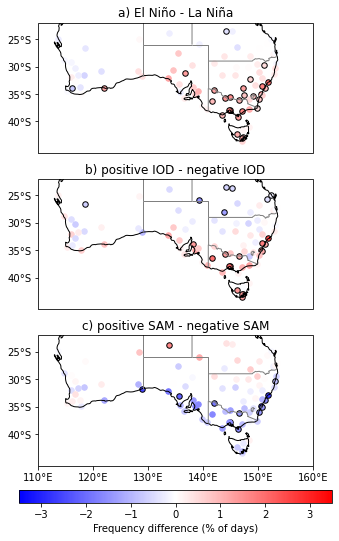

In [14]:
latlon=pandas.read_csv('../data/acorn_sat/acorn_sat_v2.1.0_daily_tmax/acorn_sat_v2.1.0_stations.csv',usecols=[0,2,3]).to_xarray().swap_dims({"index": "stn_num"})
ids=ids.astype(int)
norm=colors.Normalize(vmin=-3.5,vmax=3.5)
s_size=30
cm = 1/2.54

fig=plt.figure(figsize=(19*cm,23*cm))
ax1 = fig.add_subplot(3, 1, 1, projection=ccrs.PlateCarree())
ax1.set_extent([110,160,-22,-43])
ax1.add_feature(cline50m,edgecolor='k')
ax1.add_feature(states_provinces,edgecolor='gray')
for m in range(len(ids)):
    if p_list[m]<=0.05:
        sc=ax1.scatter(latlon['lon'].loc[ids[m]],latlon['lat'].loc[ids[m]],marker='o',s=s_size,c=100*freq_diff_list[m],edgecolors='k',norm=norm,cmap='bwr',transform=ccrs.PlateCarree())
    else:
        sc=ax1.scatter(latlon['lon'].loc[ids[m]],latlon['lat'].loc[ids[m]],marker='o',s=s_size,c=100*freq_diff_list[m],norm=norm,cmap='bwr',transform=ccrs.PlateCarree())
#ax.gridlines()
#ax1.set_xticks([110,120,130,140,150,160], crs=ccrs.PlateCarree())
ax1.set_yticks([-25,-30,-35,-40], crs=ccrs.PlateCarree())
#lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
#ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_title('a) El Niño - La Niña')


ax2 = fig.add_subplot(3, 1, 2, projection=ccrs.PlateCarree())
ax2.set_extent([110,160,-22,-43])
ax2.add_feature(cline50m,edgecolor='k')
ax2.add_feature(states_provinces,edgecolor='gray')
for m in range(len(ids)):
    if p_list_iod[m]<=0.05:
        sc=ax2.scatter(latlon['lon'].loc[ids[m]],latlon['lat'].loc[ids[m]],marker='o',s=s_size,c=100*freq_diff_list_iod[m],edgecolors='k',norm=norm,cmap='bwr',transform=ccrs.PlateCarree())
    else:
        sc=ax2.scatter(latlon['lon'].loc[ids[m]],latlon['lat'].loc[ids[m]],marker='o',s=s_size,c=100*freq_diff_list_iod[m],norm=norm,cmap='bwr',transform=ccrs.PlateCarree())
#ax.gridlines()
#ax2.set_xticks([110,120,130,140,150,160], crs=ccrs.PlateCarree())
ax2.set_yticks([-25,-30,-35,-40], crs=ccrs.PlateCarree())
#lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
#ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_title('b) positive IOD - negative IOD')


ax3 = fig.add_subplot(3, 1, 3, projection=ccrs.PlateCarree())
ax3.set_extent([110,160,-22,-43])
ax3.add_feature(cline50m,edgecolor='k')
ax3.add_feature(states_provinces,edgecolor='gray')
for m in range(len(ids)):
    if p_list_sam[m]<=0.05:
        sc=ax3.scatter(latlon['lon'].loc[ids[m]],latlon['lat'].loc[ids[m]],marker='o',s=s_size,c=100*freq_diff_list_sam[m],edgecolors='k',norm=norm,cmap='bwr',transform=ccrs.PlateCarree())
    else:
        sc=ax3.scatter(latlon['lon'].loc[ids[m]],latlon['lat'].loc[ids[m]],marker='o',s=s_size,c=100*freq_diff_list_sam[m],norm=norm,cmap='bwr',transform=ccrs.PlateCarree())
#ax.gridlines()
ax3.set_xticks([110,120,130,140,150,160], crs=ccrs.PlateCarree())
ax3.set_yticks([-25,-30,-35,-40], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.set_title('c) positive SAM - negative SAM')
cbar = fig.colorbar(sc,ax=[ax1,ax2,ax3],orientation='horizontal',fraction=.05,pad=0.05,aspect=25,shrink=.75)
cbar.set_label("Frequency difference (% of days)")

#plt.tight_layout()
plt.savefig('fig4.pdf',bbox_inches='tight')
plt.show()